# Unsupervised Analysis: Comprehensive Study of Urban Morphology and Environment

This notebook provides a deep dive into the unsupervised learning analysis of the Geneva dataset. We explore the structural relationships between Environmental Quality (EQ) and Urban Morphology using a suite of advanced techniques.

**Objectives**
1.  **Dimensionality Reduction**: Understand the complexity of our data using PCA.
2.  **Latent Correlation**: Quantify the link between environment and form using CCA and interpret the drivers.
3.  **Clustering**: Identify distinct typologies of neighborhoods. **Note**: Given the small dataset size, we prioritize Hierarchical Clustering over density-based methods.
4.  **Manifold Visualization**: Visualize the high-dimensional landscape.
5.  **Surrogate Validation**: Test if environmental features can predict morphological structure, interpreted via **SHAP**.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.cluster import AgglomerativeClustering

# Add project root to path
current_dir = Path.cwd()
if str(current_dir.parent) not in sys.path:
    sys.path.append(str(current_dir.parent))

# Imports from the unsupervised module
from src.unsupervised.data_loader import load_and_split_data
from src.unsupervised.unsupervised import UnsupervisedAnalyzer
from src.unsupervised.surrogate import SurrogateModel

%matplotlib inline
sns.set_theme(style="whitegrid")

## 1. Data Loading and Preprocessing

We load the integrated data and split it into two views:
- **X (Environment)**: Noise, Pollution, Solar, etc.
- **Y (Morphology)**: Density, Heights, Road Networks, etc.
- **Meta**: Typology labels and pre-computed PCs.

The data is standardized (mean=0, std=1) to ensure fair comparison in distance-based algorithms.

In [2]:
data_path = current_dir.parent / "data" / "morphology_EQ_Geneva_Integrated.csv"
X, Y, meta = load_and_split_data(data_path)

print(f"Loaded {X.shape[0]} samples.")
print(f"Environmental Features ({X.shape[1]}): {X.columns.tolist()}")
print(f"Morphological Features ({Y.shape[1]}): {Y.columns.tolist()}")

Loaded 240 samples.
Environmental Features (8): ['lst_mean', 'solar_summ', 'solar_wint', 'pm10_mean', 'pm25_mean', 'no2_mean', 'noiseday_m', 'noisenight']
Morphological Features (13): ['building_height', 'height_varability', 'sky_view_factor', 'frontal_area_index', 'water_cover_fraction', 'impervious_surface_cover_fraction', 'building_cover_fraction', 'pervious_surface_cover_fraction', 'aspect_ratio', 'intersections', 'length_primary_road', 'length_secondary_road', 'length_railway']


## 2. Principal Component Analysis (PCA)

Quick check of the explained variance to understand dimensionality.

PCA on Environment (X):
PCA: 4 components explain 95.52% of variance.


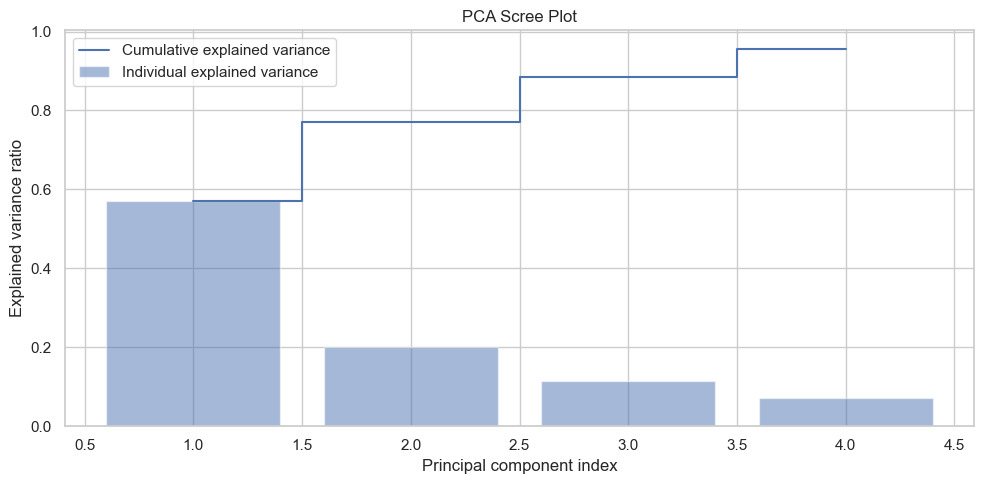

PCA on Morphology (Y):
PCA: 7 components explain 96.17% of variance.


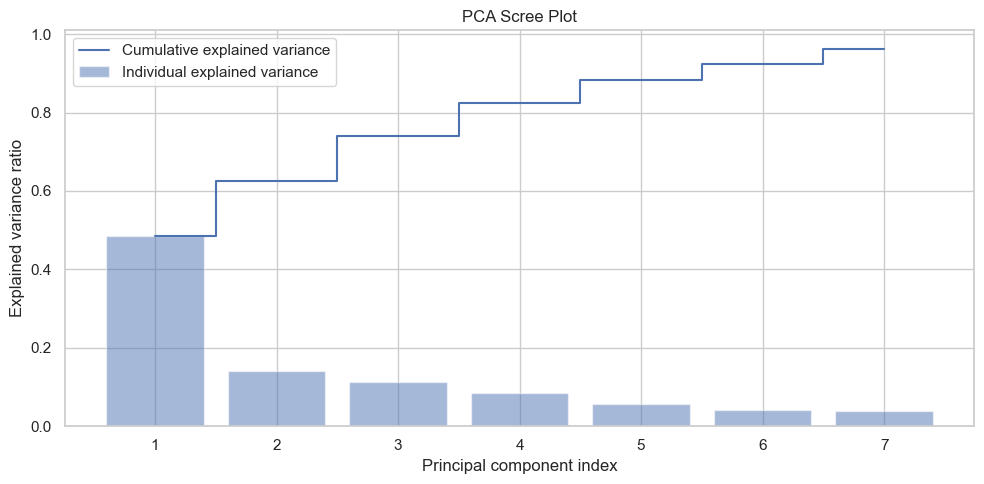

In [3]:
analyzer = UnsupervisedAnalyzer()
print("PCA on Environment (X):")
pca_x, _, _ = analyzer.run_pca(X)
analyzer.plot_pca_start(pca_x)

print("PCA on Morphology (Y):")
pca_y, _, _ = analyzer.run_pca(Y)
analyzer.plot_pca_start(pca_y)

## 3. Canonical Correlation Analysis (CCA)

CCA finds linear combinations of X and Y that are maximally correlated. This helps us understand if there's a strong shared structure between the two domains.

CCA Correlations (Top 2 components): [np.float64(0.6444294443099308), np.float64(0.40507657075377246)]


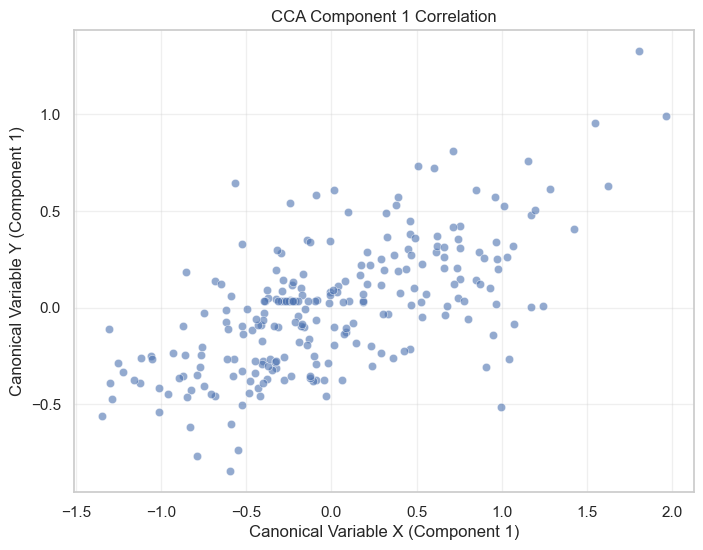

In [4]:
cca, X_c, Y_c = analyzer.run_cca(X, Y, n_components=2)
analyzer.plot_cca_results(X_c, Y_c, component_idx=0)

### Interpretation of CCA Loadings
Which features drive this correlation? The loadings show the correlation between the original features and the Canonical Variates.

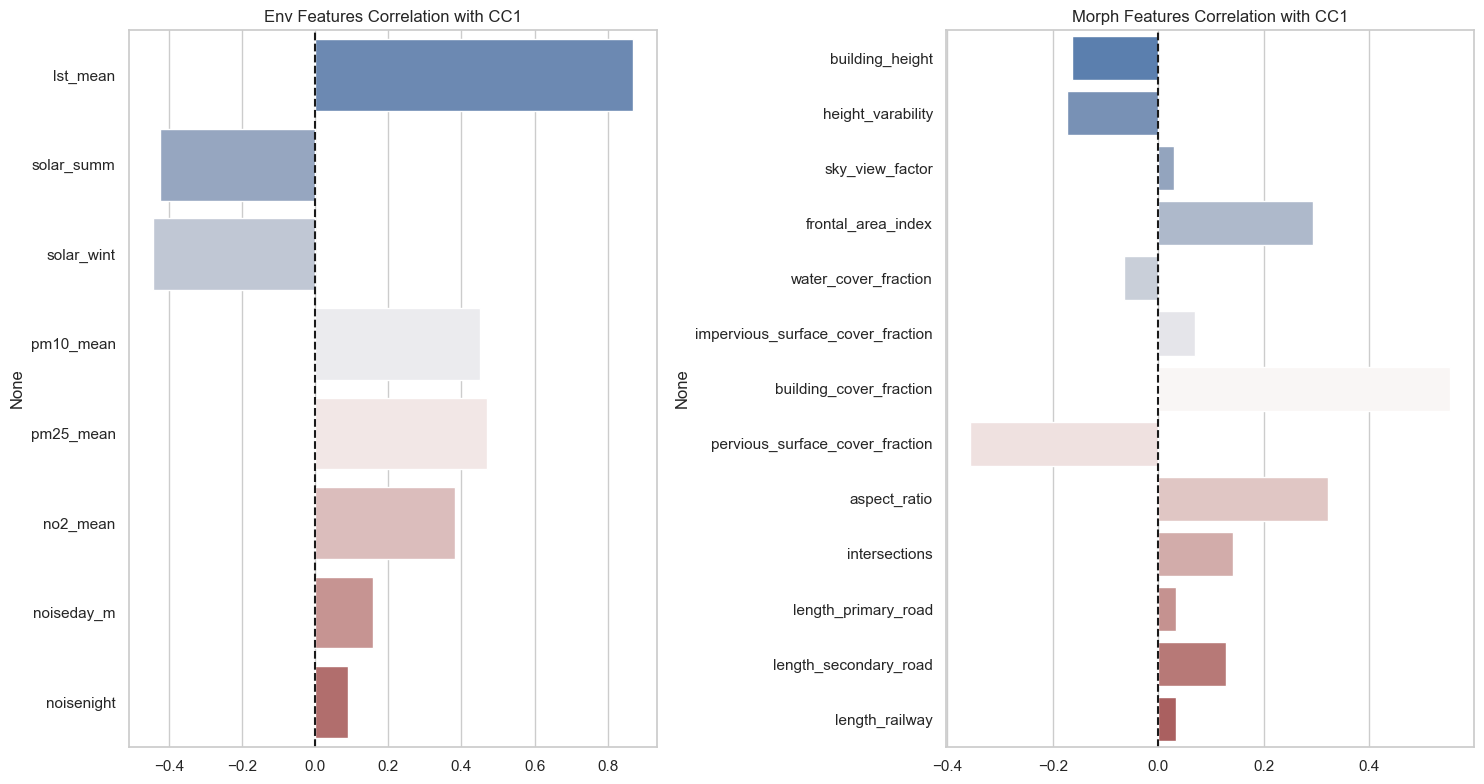

In [5]:
analyzer.plot_cca_loadings(X, Y, cca, component=0)

## 4. Clustering Analysis

Given the limited number of samples, **Hierarchical Clustering** is often more robust than density-based methods (like DBSCAN) as it doesn't rely on local density thresholds. We inspect the Dendrogram to determine the natural number of clusters.

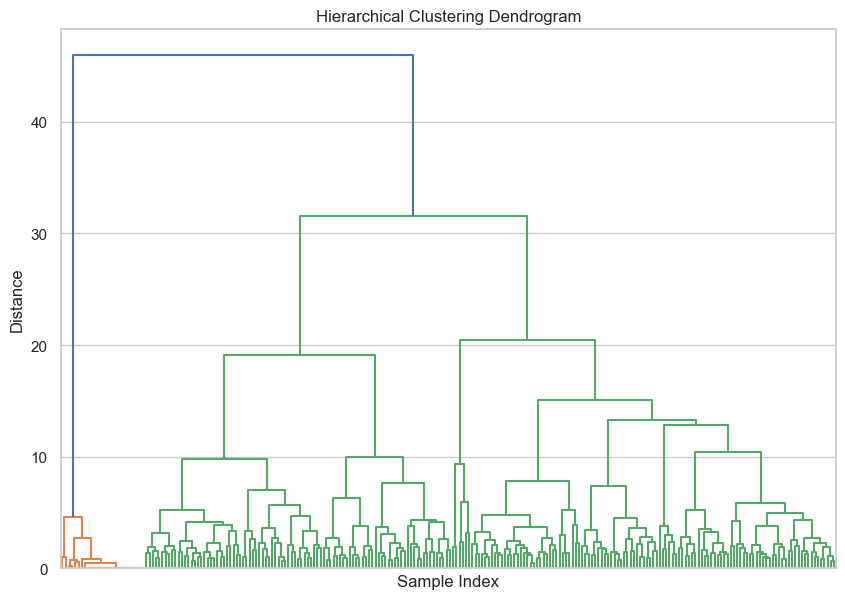

In [6]:
# 1. Hierarchical Clustering Dendrogram
analyzer.run_hierarchical_clustering(Y, method="ward")

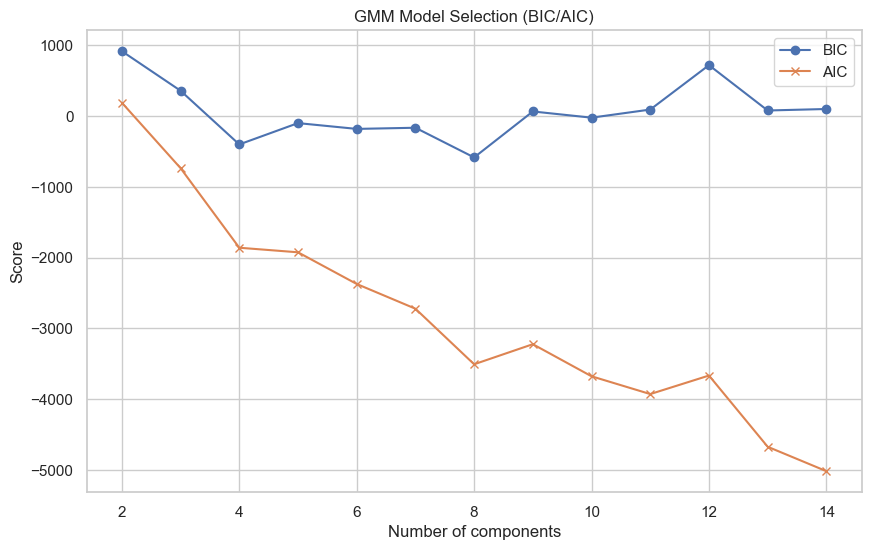

In [13]:
# 2. Model Selection Guidance (GMM BIC/AIC)
# This helps confirm if the number of clusters suggested by the dendrogram is statistically sound.
_ = analyzer.run_gmm(Y, n_components_range=range(2, 15))

In [8]:
# 3. Apply Agglomerative Clustering
# Based on Dendrogram and GMM, we choose a reasonable k (e.g., 3 or 4).
k_clusters = 8  # Adjust this based on the Dendrogram visual
print(f"Applying Agglomerative Clustering with k={k_clusters}...")

hc = AgglomerativeClustering(n_clusters=k_clusters)
labels_morph = hc.fit_predict(Y)

analyzer.evaluate_clustering(Y, labels_morph)

Applying Agglomerative Clustering with k=8...
Clustering Evaluation (n=8):
  Silhouette Score: 0.2542
  Calinski-Harabasz Score: 83.0290


{'silhouette': 0.2542001864946403, 'calinski': 83.02900971381177}

### Cluster Profiling
Values shown are Z-scores (deviations from the mean).

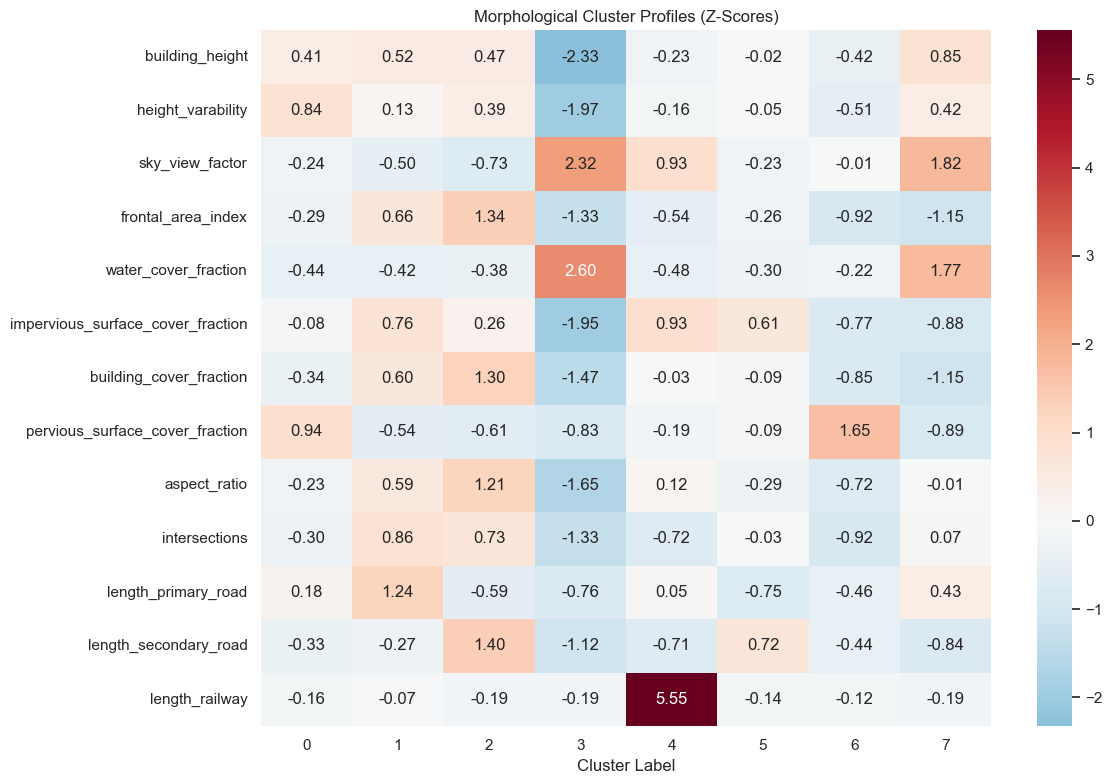

In [9]:
analyzer.plot_cluster_profile(
    Y, labels_morph, title="Morphological Cluster Profiles (Z-Scores)"
)

## 5. Manifold Learning
Visualizing the high-dimensional morphology space in 2D, colored by our new clusters.

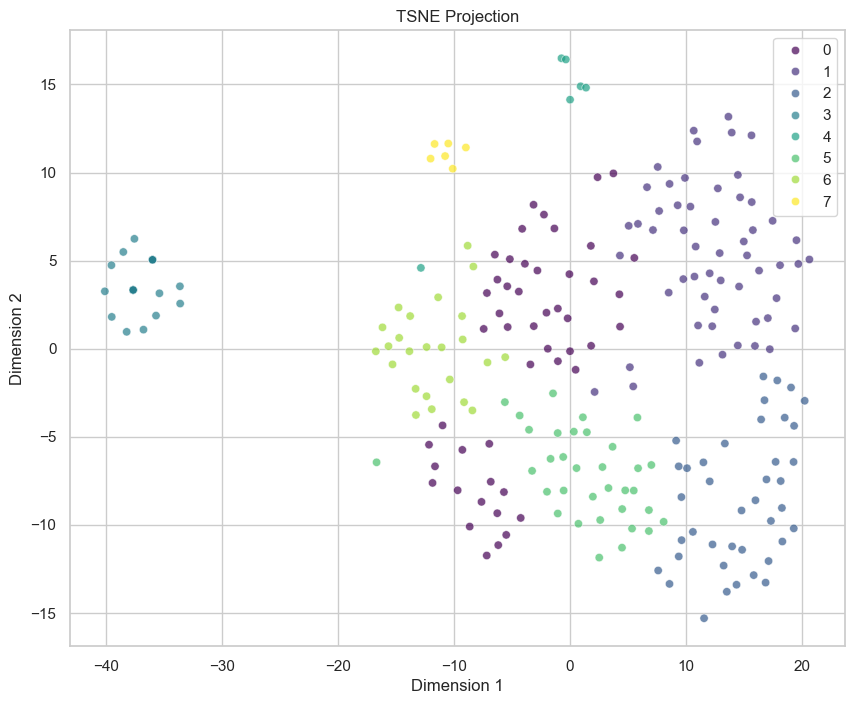

In [10]:
analyzer.run_manifold_learning(Y, color_by=labels_morph, method="tsne")

## 6. Surrogate Learning: Env -> Morph

**Objective**: Can environmental quality predict the morphological structure? 
We use **SHAP (SHapley Additive exPlanations)** to interpret the models.

--- I. Regression: Predicting Morphological Features directly ---
Surrogate Model (Ridge) Performance:
  Avg R2: -0.0728
  RMSE: 1.0444

[Regression SHAP] Understanding environmental drivers for morphology:
Running SHAP analysis on the first target dimension...


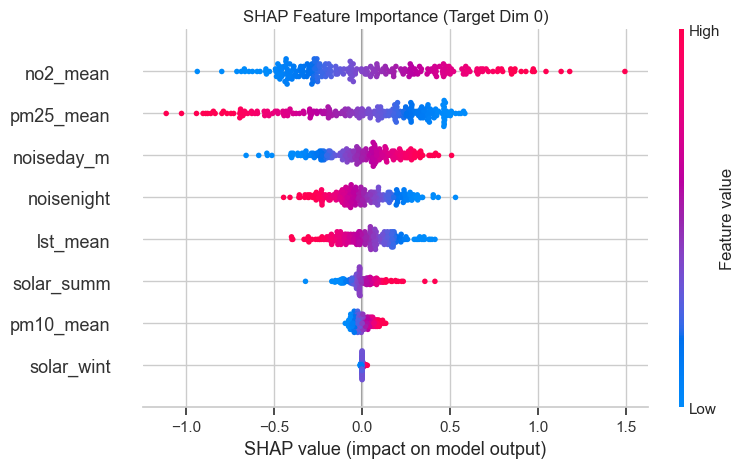

In [11]:
print("--- I. Regression: Predicting Morphological Features directly ---")
surrogate = SurrogateModel(model_type="ridge")
surrogate.train(X, Y)

# SHAP Analysis for Regression
print("\n[Regression SHAP] Understanding environmental drivers for morphology:")
surrogate.analyze_feature_importance(X)


Classification Report (Env -> Morph Cluster):
              precision    recall  f1-score   support

           0       0.40      0.59      0.48        49
           1       0.25      0.24      0.24        55
           2       0.26      0.33      0.29        40
           3       0.55      0.46      0.50        26
           4       0.00      0.00      0.00         6
           5       0.17      0.15      0.16        34
           6       0.08      0.04      0.05        24
           7       0.00      0.00      0.00         6

    accuracy                           0.30       240
   macro avg       0.21      0.23      0.21       240
weighted avg       0.27      0.30      0.28       240



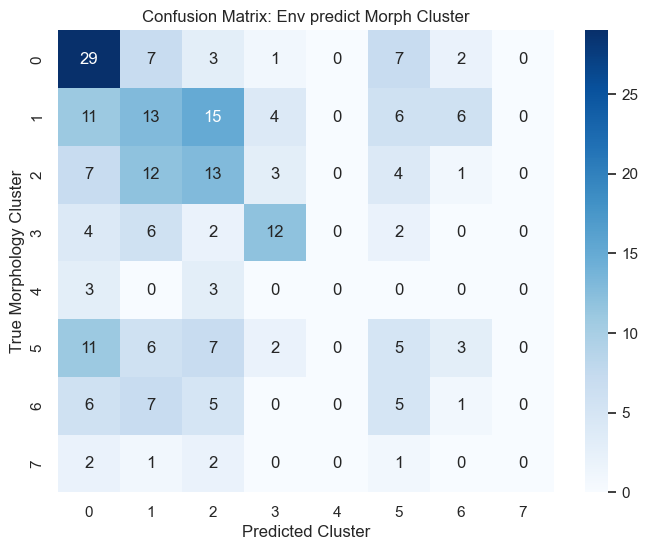

<Figure size 640x480 with 0 Axes>

Running SHAP analysis for Classification...


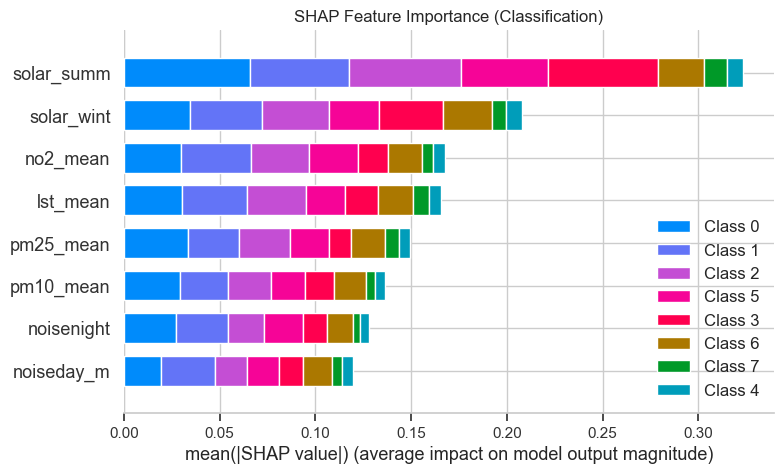

In [12]:
# Evaluate Classification (Env -> Morph Cluster)
# This includes SHAP analysis for the Classifier
surrogate.evaluate_classification(X, labels_morph)